In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import textstat
import matplotlib.pyplot as plt
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV

2025-07-30 02:47:37.596333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753843657.622230     125 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753843657.630088     125 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading the data

In [3]:
# Load the files
df = pd.read_csv("/kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv")
print("Loaded train.csv with shape:", df.shape)

Loaded train.csv with shape: (95, 2)


In [4]:
train_path = Path("/kaggle/input/fake-or-real-the-impostor-hunt/data/train")

def load_train(row):
    folder = train_path / f"article_{row['id']:04d}"
    with open(folder / "file_1.txt", "r", encoding="utf-8") as f1:
        text1 = f1.read()
    with open(folder / "file_2.txt", "r", encoding="utf-8") as f2:
        text2 = f2.read()
    return pd.Series([text1, text2])

df[["text_1", "text_2"]] = df.apply(load_train, axis=1)
print("Loaded all text files!")

# Drop rows with empty file_1 or file_2
empty = (df["text_1"].str.strip() == "") | (df["text_2"].str.strip() == "")
print(f"Dropping {empty.sum()} rows with empty text files.")
df = df[~empty].reset_index(drop=True)

# Labels
y = (df["real_text_id"] == 2).astype(int)  # 1 if file_2 is real    

Loaded all text files!
Dropping 2 rows with empty text files.


# Exploratory Data Analysis


Difference in character length (text_1 - text_2):
count       93.000000
mean      1051.043011
std       5033.334315
min      -8521.000000
25%       -219.000000
50%        142.000000
75%        975.000000
max      38648.000000
Name: len_diff, dtype: float64

Character length statistics:
Text 1 - mean: 2992.7741935483873 min: 195 max: 40316
Text 2 - mean: 1941.731182795699 min: 69 max: 9561


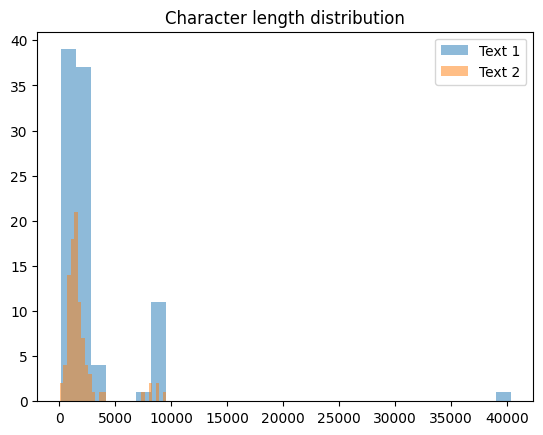

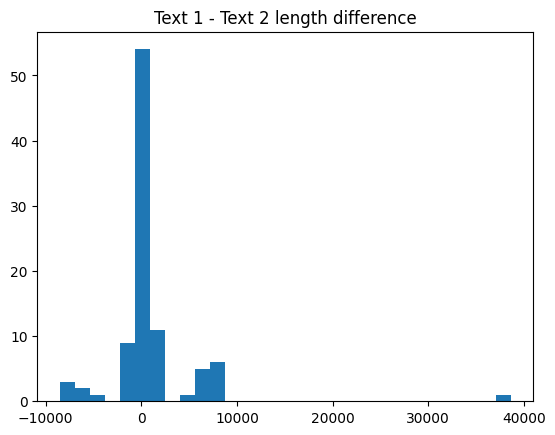

In [5]:
# Compare lengths
df["len_1"] = df["text_1"].str.len()
df["len_2"] = df["text_2"].str.len()
df["len_diff"] = df["len_1"] - df["len_2"]

print("\nDifference in character length (text_1 - text_2):")
print(df["len_diff"].describe())

# Print summary stats
print("\nCharacter length statistics:")
print("Text 1 - mean:", df["len_1"].mean(), "min:", df["len_1"].min(), "max:", df["len_1"].max())
print("Text 2 - mean:", df["len_2"].mean(), "min:", df["len_2"].min(), "max:", df["len_2"].max())

# Check distributions
plt.hist(df["len_1"], bins=30, alpha=0.5, label="Text 1")
plt.hist(df["len_2"], bins=30, alpha=0.5, label="Text 2")
plt.legend()
plt.title("Character length distribution")
plt.show()

plt.hist(df["len_diff"], bins=30)
plt.title("Text 1 - Text 2 length difference")
plt.show()

In [6]:
print("Empty text_1 count:", (df["len_1"] == 0).sum())
print("Empty text_2 count:", (df["len_2"] == 0).sum())

empty_text1_ids = df.loc[df["len_1"] == 0, "id"]
empty_text2_ids = df.loc[df["len_2"] == 0, "id"]

print("IDs with empty text_1:", empty_text1_ids.tolist())
print("IDs with empty text_2:", empty_text2_ids.tolist())

Empty text_1 count: 0
Empty text_2 count: 0
IDs with empty text_1: []
IDs with empty text_2: []


In [7]:
df["wordcount_1"] = df["text_1"].str.split().apply(len)
df["wordcount_2"] = df["text_2"].str.split().apply(len)

# Difference in length
df["wordcount_diff"] = df["wordcount_1"] - df["wordcount_2"]

print("\nDifference in word count (text_1 - text_2):")
print(df["wordcount_diff"].describe())

print("\nWord count statistics:")
print("Text 1 - mean:", df["wordcount_1"].mean(), "min:", df["wordcount_1"].min(), "max:", df["wordcount_1"].max())
print("Text 2 - mean:", df["wordcount_2"].mean(), "min:", df["wordcount_2"].min(), "max:", df["wordcount_2"].max())


Difference in word count (text_1 - text_2):
count      93.000000
mean      113.881720
std       507.673463
min      -791.000000
25%       -41.000000
50%        19.000000
75%       169.000000
max      3902.000000
Name: wordcount_diff, dtype: float64

Word count statistics:
Text 1 - mean: 383.247311827957 min: 34 max: 4158
Text 2 - mean: 269.36559139784947 min: 9 max: 957


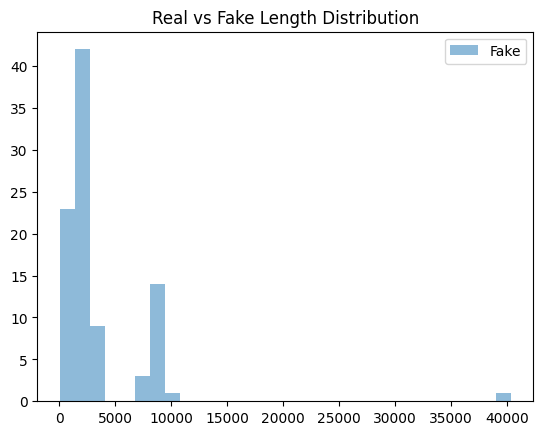

Average real length: 1439.236559139785
Average fake length: 3495.2688172043013


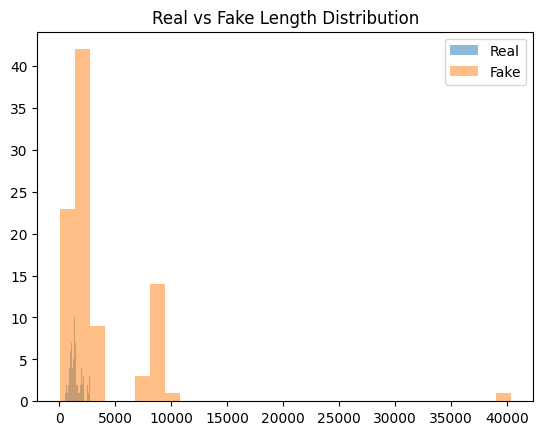

count      93.000000
mean     1439.236559
std       502.188393
min       552.000000
25%      1070.000000
50%      1368.000000
75%      1668.000000
max      2734.000000
Name: real_len, dtype: float64
count       93.000000
mean      3495.268817
std       4770.938300
min         69.000000
25%       1427.000000
50%       1905.000000
75%       3084.000000
max      40316.000000
Name: fake_len, dtype: float64


In [8]:
# Real vs Fake length comparison
df["real_len"] = df.apply(lambda row: row["len_1"] if row["real_text_id"] == 1 else row["len_2"], axis=1)
df["fake_len"] = df.apply(lambda row: row["len_2"] if row["real_text_id"] == 1 else row["len_1"], axis=1)

# plt.hist(df["real_len"], bins=30, alpha=0.5, label="Real")
plt.hist(df["fake_len"], bins=30, alpha=0.5, label="Fake")
plt.legend()
plt.title("Real vs Fake Length Distribution")
plt.show()

print("Average real length:", df["real_len"].mean())
print("Average fake length:", df["fake_len"].mean())

plt.hist(df["real_len"], bins=30, alpha=0.5, label="Real")
plt.hist(df["fake_len"], bins=30, alpha=0.5, label="Fake")
plt.legend()
plt.title("Real vs Fake Length Distribution")
plt.show()

print(df["real_len"].describe())
print(df["fake_len"].describe())

In [9]:
df["readability_1"] = df["text_1"].apply(textstat.flesch_reading_ease)
df["readability_2"] = df["text_2"].apply(textstat.flesch_reading_ease)

df["real_readability"] = df.apply(lambda row: row["readability_1"] if row["real_text_id"] == 1 else row["readability_2"], axis=1)
df["fake_readability"] = df.apply(lambda row: row["readability_2"] if row["real_text_id"] == 1 else row["readability_1"], axis=1)

print("Average Real Readability:", df["real_readability"].mean())
print("Average Fake Readability:", df["fake_readability"].mean())

print("Real Text Readability Stats:")
print(df["real_readability"].describe())

print("\nFake Text Readability Stats:")
print(df["fake_readability"].describe())

Average Real Readability: 25.859487015130814
Average Fake Readability: 27.140200435051327
Real Text Readability Stats:
count    93.000000
mean     25.859487
std      15.315784
min     -17.445969
25%      16.662500
50%      24.926733
75%      37.648835
max      56.119318
Name: real_readability, dtype: float64

Fake Text Readability Stats:
count    93.000000
mean     27.140200
std      19.650063
min     -66.226250
25%      11.780566
50%      28.437045
75%      40.162228
max      68.431667
Name: fake_readability, dtype: float64


In [10]:
def type_token_ratio(text):
    tokens = text.split()
    return len(set(tokens)) / len(tokens) if tokens else 0

df["ttr_1"] = df["text_1"].apply(type_token_ratio)
df["ttr_2"] = df["text_2"].apply(type_token_ratio)

df["real_ttr"] = df.apply(lambda row: row["ttr_1"] if row["real_text_id"] == 1 else row["ttr_2"], axis=1)
df["fake_ttr"] = df.apply(lambda row: row["ttr_2"] if row["real_text_id"] == 1 else row["ttr_1"], axis=1)

print("Average TTR (real):", df["real_ttr"].mean())
print("Average TTR (fake):", df["fake_ttr"].mean())

print(df["real_ttr"].describe())
print(df["fake_ttr"].describe())

Average TTR (real): 0.7261855560799824
Average TTR (fake): 0.7539582430558989
count    93.000000
mean      0.726186
std       0.075499
min       0.566474
25%       0.676596
50%       0.726776
75%       0.767956
max       0.923077
Name: real_ttr, dtype: float64
count    93.000000
mean      0.753958
std       0.140595
min       0.265306
25%       0.668281
50%       0.730769
75%       0.814371
max       0.993342
Name: fake_ttr, dtype: float64


# Loading the Sentence Transformer for Encoding

In [11]:
print("Generating sentence embeddings...")
transformer = SentenceTransformer("all-mpnet-base-v2")
emb_1 = transformer.encode(df["text_1"].tolist(), convert_to_numpy=True, show_progress_bar=True)
emb_2 = transformer.encode(df["text_2"].tolist(), convert_to_numpy=True, show_progress_bar=True)

Generating sentence embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

# Extracing features from the embeddings

In [12]:
def extract_features(df, emb_1, emb_2):
    df["len_1"] = df["text_1"].str.len()
    df["len_2"] = df["text_2"].str.len()
    df["len_diff"] = df["len_1"] - df["len_2"]

    df["wordcount_1"] = df["text_1"].str.split().apply(len)
    df["wordcount_2"] = df["text_2"].str.split().apply(len)
    df["wordcount_diff"] = df["wordcount_1"] - df["wordcount_2"]

    df["cosine_sim"] = [cosine_similarity([a], [b])[0][0] for a, b in zip(emb_1, emb_2)]
    
    X_simple = df[[ 
        "len_1", "len_2", "len_diff",
        "wordcount_1", "wordcount_2", "wordcount_diff",
    ]].to_numpy()

    X_simple = np.hstack([X_simple, df[["cosine_sim"]].to_numpy()])

    X_emb = np.concatenate([
        # emb_1, 
        # emb_2, 
        emb_1 - emb_2, 
        emb_1 * emb_2
    ], axis=1)

    return np.concatenate([X_emb, X_simple], axis=1)

X_combined = extract_features(df, emb_1, emb_2)
print("Completed extracting the features!")

Completed extracting the features!


# Building the model

In [13]:
def build_model(X_combined, y):
    param_dist = {
        "n_estimators": randint(100, 500),
        "max_depth": [None] + list(range(10, 80, 10)),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(1, 8),
        "max_features": ["sqrt", "log2", None]
    }

    model = RandomForestClassifier(random_state=42, n_jobs=-1)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=50,
        scoring="accuracy",
        cv=kf,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_combined, y)
    print("Best score:", search.best_score_)
    model = search.best_estimator_

    return model
    
model = build_model(X_combined, y)
print("Completed training!")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.9257309941520468
Completed training!


# Using Built model to Predict on Test files

In [14]:
test_path = Path("/kaggle/input/fake-or-real-the-impostor-hunt/data/test")

def predict_test(model):
    # === Load Test Data ===
    test_ids = sorted([d.name for d in test_path.iterdir() if d.is_dir()])
    print(f"Found {len(test_ids)} test samples.")

    test_df = pd.DataFrame({"id": [int(i.split("_")[1]) for i in test_ids]})
    test_df = test_df.sort_values("id").reset_index(drop=True)

    # === Load Texts ===
    def load_test(row):
        folder = test_path / f"article_{row['id']:04d}"
        with open(folder / "file_1.txt", "r", encoding="utf-8") as f1:
            text1 = f1.read()
        with open(folder / "file_2.txt", "r", encoding="utf-8") as f2:
            text2 = f2.read()
        return pd.Series([text1, text2])

    test_df[["text_1", "text_2"]] = test_df.apply(load_test, axis=1)
    print("Loaded all test text files.")

    # === Generate Embeddings ===
    print("Generating test sentence embeddings...")
    emb_test_1 = transformer.encode(test_df["text_1"].tolist(), convert_to_numpy=True, show_progress_bar=True)
    emb_test_2 = transformer.encode(test_df["text_2"].tolist(), convert_to_numpy=True, show_progress_bar=True)

    X_test_combined = extract_features(test_df, emb_test_1, emb_test_2)

    y_pred = model.predict(X_test_combined)

    # === Map back to real_text_id (1 or 2)
    test_df["real_text_id"] = y_pred + 1  # Because label=1 → file_2 is real → real_text_id = 2

    # === Save submission
    submission = test_df[["id", "real_text_id"]]
    submission.to_csv("/kaggle/working/submission.csv", index=False)
    print("Saved submission.csv!")

predict_test(model)

Found 1068 test samples.
Loaded all test text files.
Generating test sentence embeddings...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Saved submission.csv!
